<a href="https://colab.research.google.com/github/oanasabau1/News-Classification-Comparison-using-Machine-Learning/blob/main/news_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import re
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import seaborn as sns
import scipy.sparse as sp
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Loading the dataset
file_path = r'/content/drive/path/News_Category_Dataset_v3.json'
df = pd.read_json(file_path, lines=True)

In [ ]:
print("Total number of articles: ", df.shape[0])
print("Total number of authors: ", df["authors"].nunique())
print("Total number of unique categories: ", df["category"].nunique())

Total number of articles:  209527
Total number of authors:  29169
Total number of unique categories:  42


In [ ]:
df['category'].value_counts()

category
POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
COMEDY             5400
SPORTS             5077
BLACK VOICES       4583
HOME & LIVING      4320
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3653
WOMEN              3572
CRIME              3562
IMPACT             3484
DIVORCE            3426
WORLD NEWS         3299
MEDIA              2944
WEIRD NEWS         2777
GREEN              2622
WORLDPOST          2579
RELIGION           2577
STYLE              2254
SCIENCE            2206
TECH               2104
TASTE              2096
MONEY              1756
ARTS               1509
ENVIRONMENT        1444
FIFTY              1401
GOOD NEWS          1398
U.S. NEWS          1377
ARTS & CULTURE     1339
COLLEGE            1144
LATINO VOICES      1130
CULTURE & ARTS     1074
EDUCATI

In [ ]:
# Replace categories
df['category'] = df['category'].replace({
    "HEALTHY LIVING": "WELLNESS",
    "QUEER VOICES": "GROUPS VOICES",
    "BUSINESS": "BUSINESS & FINANCES",
    "PARENTS": "PARENTING",
    "BLACK VOICES": "GROUPS VOICES",
    "THE WORLDPOST": "WORLD NEWS",
    "STYLE": "STYLE & BEAUTY",
    "GREEN": "ENVIRONMENT",
    "TASTE": "FOOD & DRINK",
    "WORLDPOST": "WORLD NEWS",
    "SCIENCE": "SCIENCE & TECH",
    "TECH": "SCIENCE & TECH",
    "MONEY": "BUSINESS & FINANCES",
    "ARTS": "ARTS & CULTURE",
    "COLLEGE": "EDUCATION",
    "LATINO VOICES": "GROUPS VOICES",
    "CULTURE & ARTS": "ARTS & CULTURE",
    "FIFTY": "MISCELLANEOUS",
    "GOOD NEWS": "MISCELLANEOUS"
})

print("Total number of articles: ", df.shape[0])
print("Total number of authors: ", df["authors"].nunique())
print("Total number of unique categories: ", df["category"].nunique())

Total number of articles:  209527
Total number of authors:  29169
Total number of unique categories:  27


In [ ]:
df['category'].value_counts()

category
POLITICS               35602
WELLNESS               24639
ENTERTAINMENT          17362
PARENTING              12746
STYLE & BEAUTY         12068
GROUPS VOICES          12060
TRAVEL                  9900
WORLD NEWS              9542
FOOD & DRINK            8436
BUSINESS & FINANCES     7748
COMEDY                  5400
SPORTS                  5077
HOME & LIVING           4320
SCIENCE & TECH          4310
ENVIRONMENT             4066
ARTS & CULTURE          3922
WEDDINGS                3653
WOMEN                   3572
CRIME                   3562
IMPACT                  3484
DIVORCE                 3426
MEDIA                   2944
MISCELLANEOUS           2799
WEIRD NEWS              2777
RELIGION                2577
EDUCATION               2158
U.S. NEWS               1377
Name: count, dtype: int64

In [ ]:
# Drop irrelevant columns
new_df = df.drop(columns=['authors', 'link', 'date'])

In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = text.split()
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    text = ' '.join(tokens)
    return text

# Apply text preprocessing to headlines
new_df['processed_headline'] = new_df['headline'].apply(preprocess_text)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(new_df['processed_headline'], new_df['category'], test_size=0.2, random_state=42)

# Feature extraction using TF-IDF with different parameters
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 3), max_df=0.95, min_df=5)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
# Multinomial Naive Bayes
nb_classifier = MultinomialNB()
nb_param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0, 2.0]}
nb_grid_search = GridSearchCV(nb_classifier, nb_param_grid, cv=5, scoring='accuracy')
nb_grid_search.fit(X_train_tfidf, y_train)
best_nb_classifier = nb_grid_search.best_estimator_
best_nb_params = nb_grid_search.best_params_
print(f'\nBest Parameters for Naive Bayes: {best_nb_params}')

# Evaluate Naive Bayes
y_nb_pred = best_nb_classifier.predict(X_test_tfidf)

print('\nClassification Report for Naive Bayes:')
print(classification_report(y_test, y_nb_pred, zero_division=1))

print('\nConfusion Matrix for Naive Bayes:')
print(confusion_matrix(y_test, y_nb_pred))

nb_accuracy = accuracy_score(y_test, y_nb_pred)
print(f'Accuracy for Naive Bayes: {nb_accuracy:.2f}')


Best Parameters for Naive Bayes: {'alpha': 0.1}

Classification Report for Naive Bayes:
                     precision    recall  f1-score   support

     ARTS & CULTURE       0.51      0.28      0.36       770
BUSINESS & FINANCES       0.55      0.40      0.47      1571
             COMEDY       0.59      0.35      0.44      1022
              CRIME       0.51      0.56      0.53       713
            DIVORCE       0.80      0.51      0.63       664
          EDUCATION       0.51      0.19      0.28       411
      ENTERTAINMENT       0.56      0.69      0.62      3419
        ENVIRONMENT       0.52      0.31      0.39       845
       FOOD & DRINK       0.70      0.68      0.69      1697
      GROUPS VOICES       0.53      0.45      0.48      2389
      HOME & LIVING       0.76      0.54      0.64       879
             IMPACT       0.40      0.15      0.22       673
              MEDIA       0.65      0.29      0.40       607
      MISCELLANEOUS       0.38      0.10      0.15      

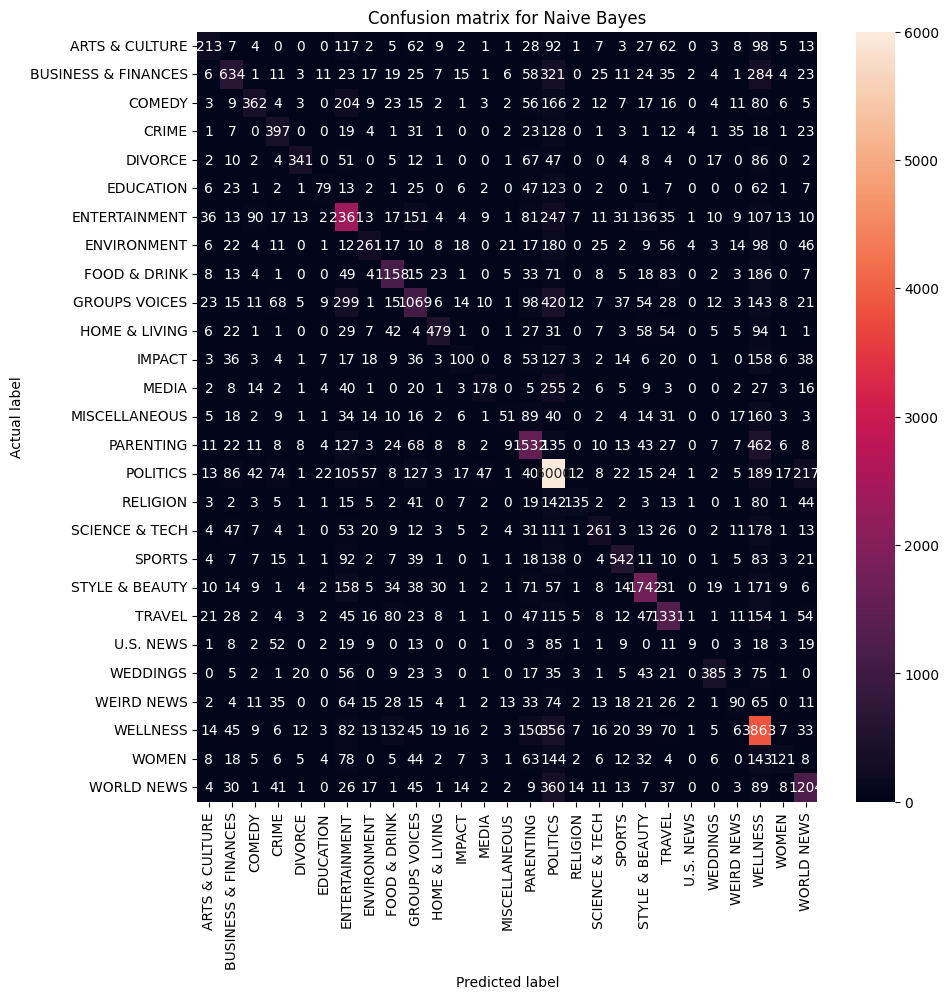

In [ ]:
# Plot confusion matrix for Naive Bayes
def plot_confusion_matrix(y_test, y_pred, labels, title):
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(y_test, y_nb_pred, labels=label_encoder.classes_, title='Confusion matrix for Naive Bayes')

In [ ]:
# Create Naive Bayes predictions as additional features
X_train_nb_pred = best_nb_classifier.predict_proba(X_train_tfidf)
X_test_nb_pred = best_nb_classifier.predict_proba(X_test_tfidf)

# Combine TF-IDF features and Naive Bayes predictions
X_train_combined = sp.hstack((X_train_tfidf, X_train_nb_pred))
X_test_combined = sp.hstack((X_test_tfidf, X_test_nb_pred))


Classification Report for Random Forest:
                     precision    recall  f1-score   support

     ARTS & CULTURE       0.46      0.34      0.39       770
BUSINESS & FINANCES       0.52      0.47      0.49      1571
             COMEDY       0.55      0.39      0.46      1022
              CRIME       0.52      0.57      0.54       713
            DIVORCE       0.77      0.60      0.68       664
          EDUCATION       0.50      0.31      0.38       411
      ENTERTAINMENT       0.61      0.69      0.64      3419
        ENVIRONMENT       0.49      0.40      0.44       845
       FOOD & DRINK       0.72      0.70      0.71      1697
      GROUPS VOICES       0.57      0.49      0.53      2389
      HOME & LIVING       0.74      0.60      0.67       879
             IMPACT       0.37      0.22      0.28       673
              MEDIA       0.62      0.30      0.40       607
      MISCELLANEOUS       0.33      0.09      0.14       533
          PARENTING       0.60      0.64  

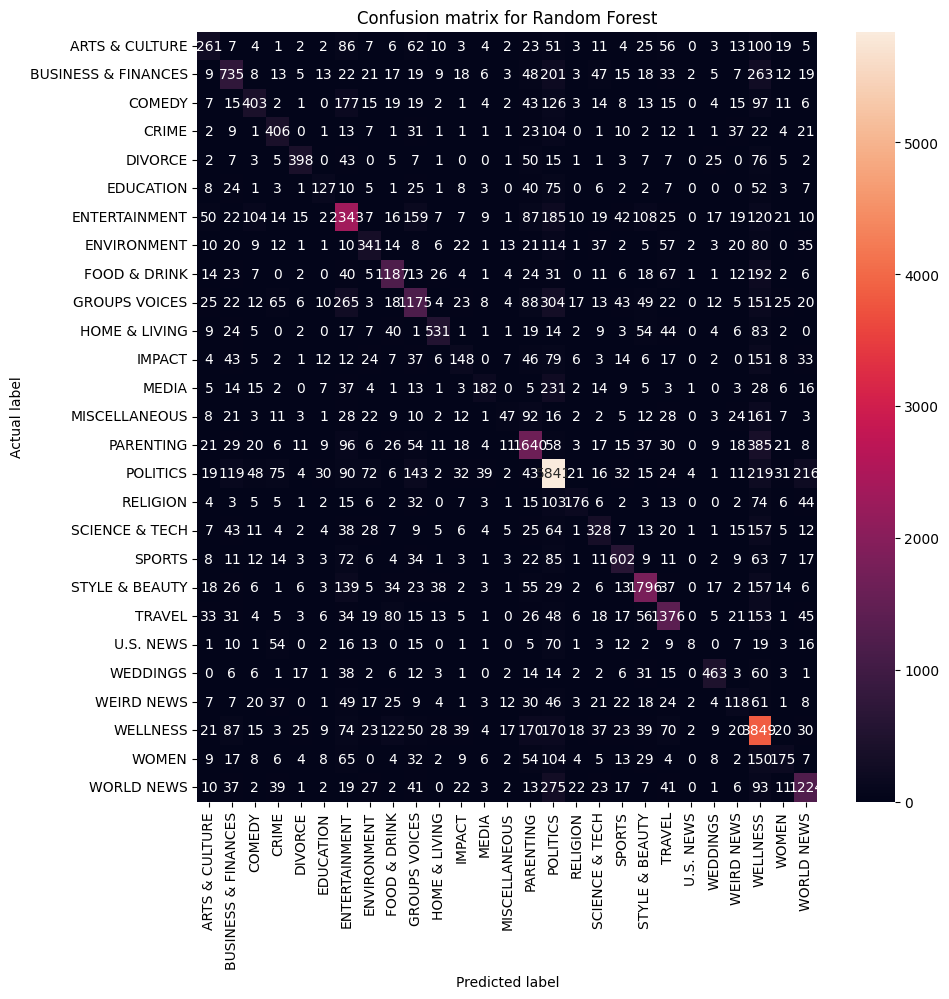

In [ ]:
# Build and train the Random Forest model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_combined, y_train_encoded)

# Evaluate the model
y_rf_pred_encoded = rf_classifier.predict(X_test_combined)
y_rf_pred = label_encoder.inverse_transform(y_rf_pred_encoded)

print('\nClassification Report for Random Forest:')
print(classification_report(y_test, y_rf_pred, zero_division=1))

print('\nConfusion Matrix for Random Forest:')
print(confusion_matrix(y_test, y_rf_pred))

rf_accuracy = accuracy_score(y_test, y_rf_pred)
print(f'Accuracy for Random Forest: {rf_accuracy:.2f}')

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, y_rf_pred, labels=label_encoder.classes_, title='Confusion matrix for Random Forest')

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



Best Parameters for Linear SVC: {'C': 0.1}

Classification Report for Linear SVC:
                     precision    recall  f1-score   support

     ARTS & CULTURE       0.54      0.34      0.41       770
BUSINESS & FINANCES       0.57      0.45      0.50      1571
             COMEDY       0.61      0.37      0.46      1022
              CRIME       0.52      0.52      0.52       713
            DIVORCE       0.82      0.63      0.71       664
          EDUCATION       0.49      0.35      0.41       411
      ENTERTAINMENT       0.61      0.70      0.65      3419
        ENVIRONMENT       0.54      0.42      0.47       845
       FOOD & DRINK       0.70      0.74      0.72      1697
      GROUPS VOICES       0.66      0.49      0.56      2389
      HOME & LIVING       0.69      0.62      0.66       879
             IMPACT       0.45      0.16      0.24       673
              MEDIA       0.62      0.36      0.46       607
      MISCELLANEOUS       0.41      0.08      0.14       533
 

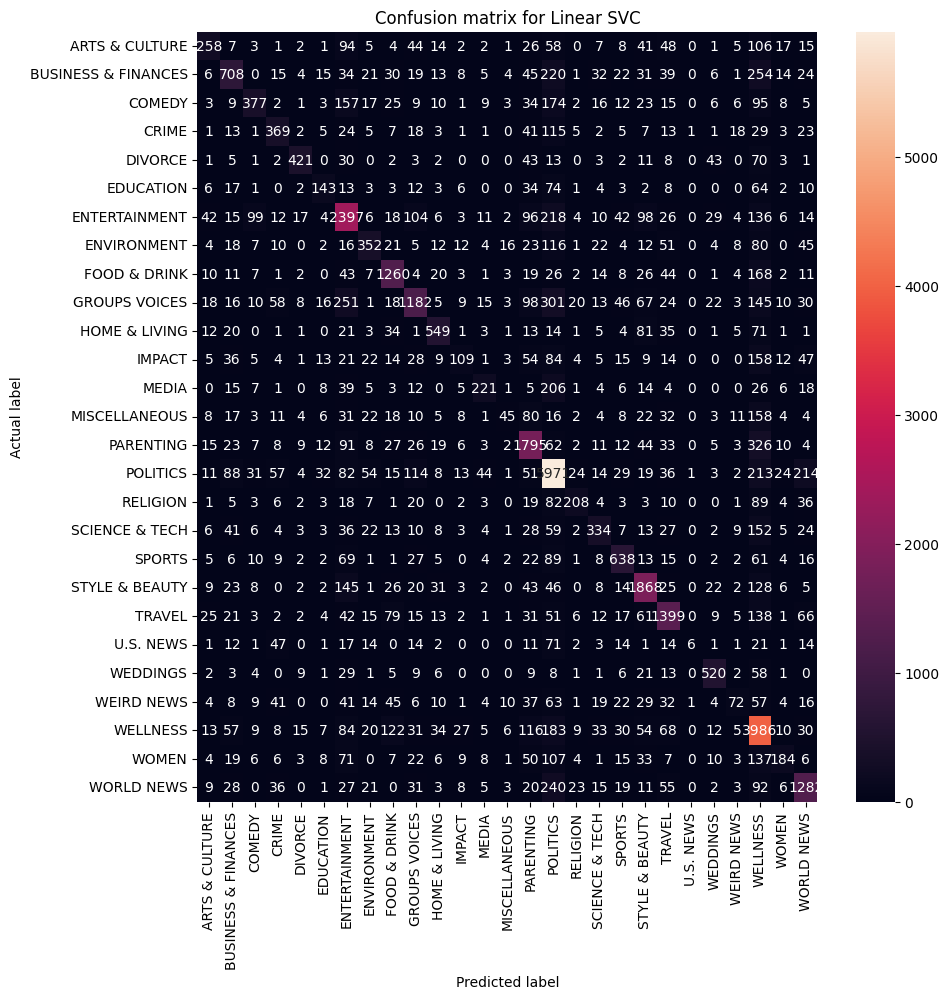

In [ ]:
# Build and train the Linear SVC model
svc_classifier = LinearSVC()
svc_param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
svc_grid_search = GridSearchCV(svc_classifier, svc_param_grid, cv=5, scoring='accuracy')
svc_grid_search.fit(X_train_tfidf, y_train_encoded)
best_svc_classifier = svc_grid_search.best_estimator_
best_svc_params = svc_grid_search.best_params_
print(f'\nBest Parameters for Linear SVC: {best_svc_params}')

# Evaluate the model
y_svc_pred_encoded = best_svc_classifier.predict(X_test_tfidf)
y_svc_pred = label_encoder.inverse_transform(y_svc_pred_encoded)

print('\nClassification Report for Linear SVC:')
print(classification_report(y_test, y_svc_pred, zero_division=1))

print('\nConfusion Matrix for Linear SVC:')
print(confusion_matrix(y_test, y_svc_pred))

svc_accuracy = accuracy_score(y_test, y_svc_pred)
print(f'Accuracy for Linear SVC: {svc_accuracy:.2f}')

# Plot confusion matrix for Linear SVC
plot_confusion_matrix(y_test, y_svc_pred, labels=label_encoder.classes_, title='Confusion matrix for Linear SVC')
